In [2]:
import pandas as pd
import numpy as np
from gnnutils import *
from models import *

2.5.1


Load model

In [3]:
# Settings
model_type = "GCN"
graphs_type = "export" # "total", "export"
layered = False
multi_graph = False
graph_identifier = f"{'multi-graph-' if multi_graph else ''}{graphs_type}{'-layered' if (layered and not multi_graph) else ''}"
seed = np.random.randint(1,10)


# Best parameters from Optuna
best_params = json.load(open("./models/best_params.json", "r"))
best_params = best_params[model_type][graph_identifier]
print(f"{model_type} | {graph_identifier} :: {best_params}")

GCN | export :: {'n_layers': 2, 'hidden_channels': 64, 'lr': 0.00234, 'weight_decay': 0.00136, 'dropout': 0.11582, 'optimizer': 'AdamW'}


Load graphs

In [4]:
# Load graphs
print("Looking for pre-loaded graphs...")
train_graphs, test_graphs = get_preloaded_graphs(path=f"../../data/graphs_data/{'multi-graph/' if multi_graph else ''}{graphs_type}")
print("Found pre-loaded graphs!")

if layered:
    # Read layer embeddings
    layer_embeddings = pickle.load(open("layer_embeddings.pickle", "rb"))
    train_graphs, test_graphs = append_layer_embedding(train_graphs, test_graphs, layer_embeddings, multi_graph=multi_graph)


# Graph constants
num_classes = 1
num_features = test_graphs[0].num_features    
pos_weight = get_pos_weight(train_graphs=train_graphs)


Looking for pre-loaded graphs...
Found pre-loaded graphs!
Pos Weight:  tensor([42.4458])


In [5]:
GCNmodel = GCN(num_features=num_features, hidden_channels=best_params["hidden_channels"], num_classes=num_classes, \
                n_layers=best_params["n_layers"], dropout=best_params["dropout"])

In [6]:
# Load best model from training for evaluation
GCNmodel.load_state_dict(torch.load(f"./models/training/{model_type}/{graph_identifier}/{seed}/best_model.pt", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
pred, y, probs = test(GCNmodel, test_graphs[0], return_probs=True)

Fraction of Affected Nodes (F)

In [8]:
len(pred[pred==1]) / test_graphs[0].num_nodes

0.19444444444444445

Volume-Weighted Affectedness (V)

In [9]:
nodes = pd.read_csv("../../data/graphs_data/export/node_features-2021-01-export.csv")
edges = pd.read_csv("../../data/graphs_data/export/edge_features-2021-01-export.csv")

In [ ]:
nodes["prob"] = probs
nodes.head()

,country_id,coi,eci,prod_num,rca,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,geo_7,geo_8,risk,trustworthiness,prob,pred
0,533,-0.190685,0.751200,0.171391,-0.221934,-0.516217,-0.900333,1.000586,1.165639,-0.101055,-0.847082,0.388420,-0.017924,0.346815,-0.030552,0.001744,0.001744
1,4,-0.865018,-1.157352,0.626029,-0.159463,0.907876,-0.147975,-1.016646,-0.233918,-0.624493,0.790410,0.025175,-0.611724,0.578374,-6.907755,0.006541,0.006541
2,24,-1.185739,-1.346742,0.626029,-0.193570,-0.400008,-0.778453,-0.075021,0.727169,-0.883979,0.446822,-0.438948,0.725765,0.520145,-0.000836,0.128896,0.128896
3,660,-0.262111,1.453785,-0.737884,-0.176683,-0.768589,-0.416676,0.934601,0.983932,-0.463062,-0.869246,0.690876,-0.183451,1.000000,-6.907755,0.001271,0.001271
4,8,-0.014430,-0.316612,-0.737884,-0.352246,-0.034864,1.051710,-0.035812,0.724360,-0.576691,0.910704,0.038354,-0.458753,0.647680,-0.000333,0.004151,0.004151


In [16]:
affected_volume = edges.merge(nodes[["country_id", "prob"]], left_on="tgt", right_on="country_id", how="left")
affected_volume["export_value"] = np.exp(affected_volume.export_value)
affected_volume["affected_volume"] = (affected_volume.prob * affected_volume.export_value)

affected_volume.head()

,src,tgt,export_value,pci,num_prods,trade_agreement,country_id,prob,affected_volume
0,4,124,1096.0,-1.313411,-0.606334,-0.366644,124,4.260476e-01,466.948130
1,4,364,1208409.0,-1.313411,-0.606334,-0.253846,364,3.778980e-03,4566.553861
2,4,392,11735.0,-1.313411,-0.606334,-0.366644,392,9.981619e-01,11713.429337
3,4,586,107323.0,-1.313411,-0.606334,-0.253846,586,2.838576e-07,0.030464
4,4,724,3624.0,0.221255,-0.606334,-0.366644,724,9.956998e-01,3608.415942


In [20]:
affected_volume[affected_volume.prob > 0.5]

,src,tgt,export_value,pci,num_prods,trade_agreement,country_id,prob,affected_volume
2,4,392,11735.0,-1.313411,-0.606334,-0.366644,392,0.998162,1.171343e+04
4,4,724,3624.0,0.221255,-0.606334,-0.366644,724,0.995700,3.608416e+03
6,4,840,4561.0,-1.313411,-0.606334,-0.366644,840,0.999986,4.560935e+03
10,12,250,118489.0,-1.313411,-0.606334,-0.253846,250,0.996224,1.180415e+05
13,20,250,7658.0,0.221255,-0.606334,-0.253846,250,0.996224,7.629081e+03
...,...,...,...,...,...,...,...,...,...
4487,999,643,3726.0,-1.313411,-0.606334,-0.366644,643,0.606679,2.260486e+03
4488,999,682,921647.0,-0.039680,0.202111,-0.366644,682,0.999931,9.215833e+05
4491,999,710,475619.0,-0.719418,1.010556,-0.366644,710,1.000000,4.756190e+05
4492,999,724,54423.0,-0.615721,1.010556,-0.366644,724,0.995700,5.418897e+04


In [19]:
affected_volume[affected_volume.prob > 0.5].affected_volume.sum()

11407378410.37368

In [13]:
affected_volume.export_value.describe()

count    4.496000e+03
mean     5.029388e+06
std      4.325163e+07
min      3.000000e+00
25%      6.744000e+03
50%      5.180750e+04
75%      6.023790e+05
max      1.578160e+09
Name: export_value, dtype: float64

,src,tgt,export_value,pci,num_prods,trade_agreement,country_id,prob,affected_volume
0,4,124,6.999422,-1.313411,-0.606334,-0.366644,124,9.148276e-03,6.403265e-05
1,4,364,14.004815,-1.313411,-0.606334,-0.253846,364,1.565592e-03,2.192583e-05
2,4,392,9.370331,-1.313411,-0.606334,-0.366644,392,9.692631e-01,9.082317e-03
3,4,586,11.583598,-1.313411,-0.606334,-0.253846,586,3.921166e-10,4.542121e-12
4,4,724,8.195334,0.221255,-0.606334,-0.366644,724,9.461358e-01,7.753898e-03


In [99]:
np.exp(affected_volume.affected_volume.sum())

27288159.638061494

In [34]:
import networkx as nx
from torch_geometric.utils import to_networkx

# assume `data` is your PyG Data object for one commodity‑layer graph
# If your graph is directed, but you want undirected metrics:
G_nx = to_networkx(test_graphs[0], to_undirected=True)

# 1) Average shortest‐path length (only works on connected graphs):
if nx.is_connected(G_nx):
    avg_sp = nx.average_shortest_path_length(G_nx)
else:
    # for disconnected graphs you might do a weighted average over components
    comps = list(nx.connected_components(G_nx))
    avg_sps = []
    sizes   = []
    for comp in comps:
        sub = G_nx.subgraph(comp)
        avg_sps.append(nx.average_shortest_path_length(sub))
        sizes.append(len(comp))
    avg_sp = sum(sp*s for sp,s in zip(avg_sps, sizes)) / sum(sizes)

# 2) Global clustering coefficient:
clust = nx.transitivity(G_nx)   # or nx.average_clustering(G_nx)

# 3) Algebraic connectivity (requires scipy):
#    This is λ₂ of the Laplacian; very slow for big graphs!
try:
    alg_conn = nx.algebraic_connectivity(G_nx)
except Exception:
    alg_conn = None  # or use `nx.linalg.algebraic_connectivity` if available

# 4) Size of largest connected component:
lcc = len(max(nx.connected_components(G_nx), key=len))

print(f"avg_sp={avg_sp:.3f}, clust={clust:.3f}, alg_conn={alg_conn}, lcc={lcc}")


avg_sp=2.053, clust=0.483, alg_conn=0.8875925648808469, lcc=216


In [27]:
len(pred==1)

216

In [25]:
test_graphs[0].edge_weight[pred==1]

IndexError: The shape of the mask [216] at index 0 does not match the shape of the indexed tensor [4496] at index 0

In [22]:
probs

tensor([1.6801e-04, 8.1184e-03, 2.9653e-01, 7.0496e-05, 8.5612e-05, 2.6759e-03,
        9.9997e-01, 1.3472e-03, 1.4439e-03, 3.0946e-19, 8.3918e-01, 1.9522e-03,
        1.8435e-03, 8.4640e-04, 9.1159e-01, 3.0633e-03, 4.3619e-01, 9.9108e-04,
        3.1394e-01, 7.7328e-03, 4.5227e-04, 2.5169e-01, 4.4509e-04, 3.5846e-05,
        7.2375e-05, 5.3564e-05, 5.3250e-04, 1.7510e-05, 2.8561e-04, 3.3809e-01,
        7.4650e-04, 2.6397e-02, 9.9996e-01, 8.7743e-04, 9.1483e-03, 1.6777e-04,
        4.0346e-05, 9.3696e-02, 9.3799e-01, 5.0652e-01, 1.0000e+00, 2.5077e-01,
        3.3066e-03, 1.7778e-05, 8.9992e-01, 6.5287e-03, 2.3606e-06, 3.9711e-10,
        3.5779e-04, 5.7827e-02, 1.7648e-04, 1.3014e-03, 9.8985e-01, 3.7158e-01,
        4.0111e-05, 4.4796e-04, 8.5871e-04, 1.9778e-04, 5.7522e-05, 9.9498e-01,
        9.4614e-01, 6.6046e-05, 1.6240e-03, 1.2903e-03, 6.0584e-03, 1.2372e-02,
        9.7619e-01, 2.3978e-04, 1.9865e-03, 3.3031e-01, 9.6449e-01, 1.2204e-03,
        9.5670e-01, 1.8022e-04, 5.9671e-

In [45]:
df = pd.read_csv("../../data/graphs_data/df_impact_drop_exporters.csv")
labels = pd.read_csv("../../data/graphs_data/labels-affected_importers.csv", dtype={"product_code": str})

In [46]:
df.groupby(["pid"]).size()

pid
01     325
02     163
03     131
04      99
05     239
      ... 
95     167
96     195
97     673
99    1525
XX     112
Length: 98, dtype: int64

In [47]:
labels.groupby(["year", "product_code", "label"]).size().reset_index()

,year,product_code,label,0
0,2012,01,affected_importer,10
1,2012,01,not_affected,266
2,2012,02,affected_importer,3
3,2012,02,not_affected,273
4,2012,03,affected_importer,2
...,...,...,...,...
1576,2021,95,affected_importer,2
1577,2021,95,not_affected,274
1578,2021,96,not_affected,276
1579,2021,97,affected_importer,24


In [48]:
labels[(labels.year==2021) & (labels.product_code == 97)].country_id.unique()

array([], dtype=int64)

In [49]:
fraction_affected = labels.groupby(["year", "product_code", "label"]).size().reset_index()
fraction_affected

,year,product_code,label,0
0,2012,01,affected_importer,10
1,2012,01,not_affected,266
2,2012,02,affected_importer,3
3,2012,02,not_affected,273
4,2012,03,affected_importer,2
...,...,...,...,...
1576,2021,95,affected_importer,2
1577,2021,95,not_affected,274
1578,2021,96,not_affected,276
1579,2021,97,affected_importer,24


In [50]:
fraction_affected = pd.pivot_table(fraction_affected, values=0, index=["year", "product_code"], columns="label").fillna(0).reset_index()

In [51]:
fraction_affected["fraction"] = fraction_affected.affected_importer / fraction_affected.not_affected
fraction_affected

label,year,product_code,affected_importer,not_affected,fraction
0,2012,01,10.0,266.0,0.037594
1,2012,02,3.0,273.0,0.010989
2,2012,03,2.0,274.0,0.007299
3,2012,04,0.0,276.0,0.000000
4,2012,05,2.0,274.0,0.007299
...,...,...,...,...,...
955,2021,93,16.0,260.0,0.061538
956,2021,94,2.0,274.0,0.007299
957,2021,95,2.0,274.0,0.007299
958,2021,96,0.0,276.0,0.000000


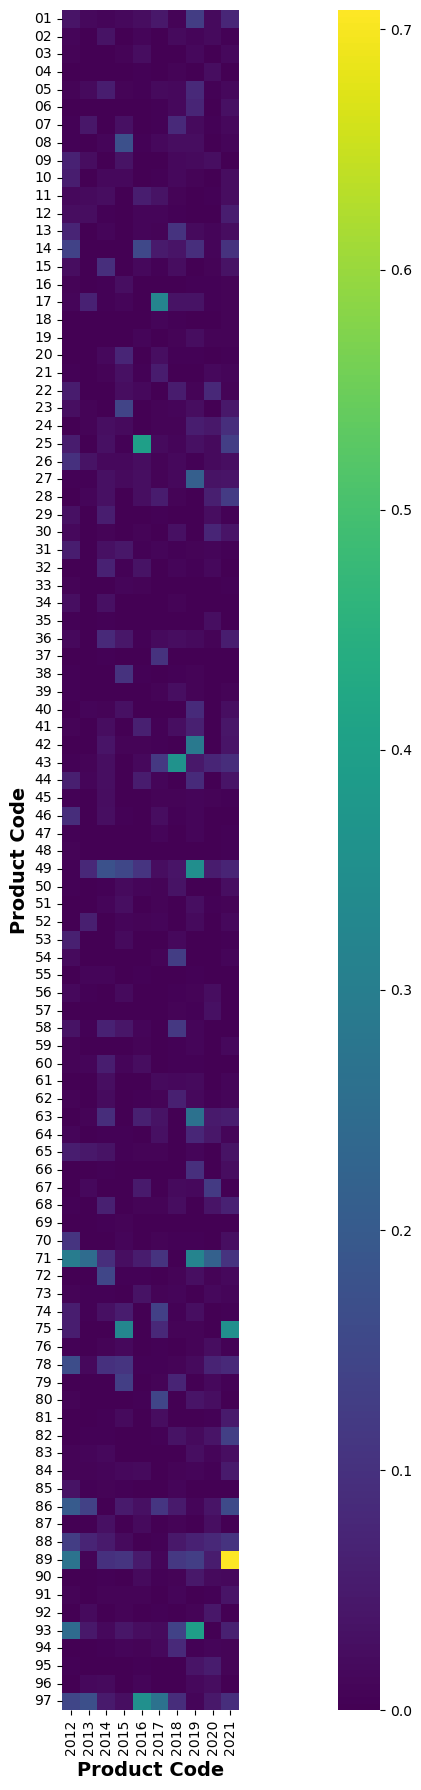

In [54]:
import seaborn as sns
#fraction_affected.product_code = fraction_affected.product_code.astype(str)

fig, ax = plt.subplots(figsize=(20, 18), dpi=100)
heatmap = sns.heatmap(fraction_affected.pivot(index="product_code", columns="year", values="fraction"), cmap='viridis', xticklabels=True, yticklabels=True, ax=ax, cbar_kws={"shrink": 1, "aspect": 40}, square=True)
#plt.title("Pairwise Cosine Similarity Heatmap of Layer Embeddings")
ax.set_xlabel("Product Code", fontsize=14, weight='bold')
ax.set_ylabel("Product Code", fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()